In [8]:
import rioxarray


population_data = rioxarray.open_rasterio(
    r"C:\Users\yanit\OneDrive\Bureau\Data Insights And Visualization\GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R5_C10.tif",
    masked=True
)

In [9]:
import geopandas as gpd
from rasterstats import zonal_stats

# Load a boundary (e.g., GeoJSON of Seoul)
joplin_boundary = gpd.read_file("joplin.geojson")

# Extract population statistics
stats = zonal_stats(
    joplin_boundary,
    population_data[0].values,  # Use the first band
    affine=population_data.rio.transform(),
    stats="sum"
)
print(f"Estimated population: {stats[0]['sum']}")

Estimated population: None


In [10]:
print("Population data CRS:")
print(population_data.rio.crs)

Population data CRS:
ESRI:54009


In [11]:
print("Joplin boundary CRS:")
print(joplin_boundary.crs)

Joplin boundary CRS:
EPSG:4326


In [12]:
joplin_boundary_moll = joplin_boundary.to_crs('ESRI:54009')

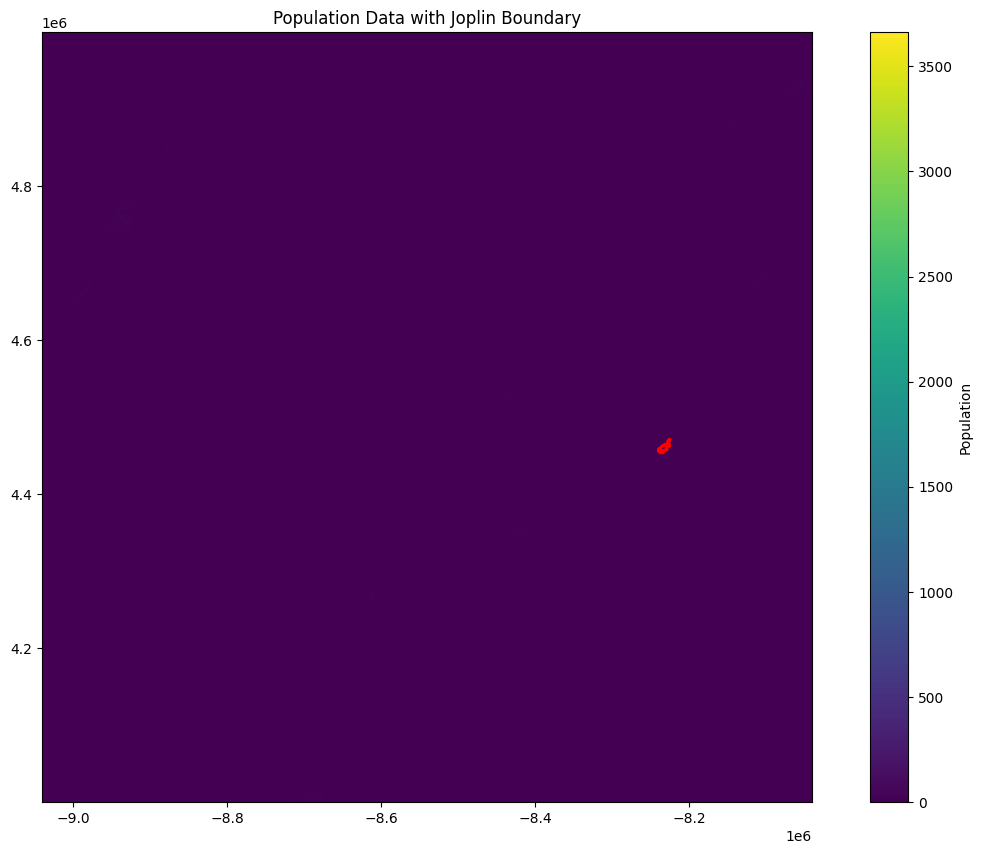

In [13]:
import matplotlib.pyplot as plt

# Create plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot population data
population = population_data[0].values
plt.imshow(population, 
          extent=[population_data.x.min(), population_data.x.max(), 
                  population_data.y.min(), population_data.y.max()],
          cmap='viridis')
plt.colorbar(label='Population')

# Plot Joplin boundary
joplin_boundary_moll.boundary.plot(ax=ax, color='red', linewidth=2)

plt.title('Population Data with Joplin Boundary')
plt.show()

In [14]:
stats = zonal_stats(
    joplin_boundary_moll,
    population_data[0].values,
    affine=population_data.rio.transform(),
    stats="sum"
)
print(f"Estimated population: {stats[0]['sum']}")

Estimated population: 54858.93593286213


In [15]:
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Load and reproject Joplin boundary
joplin_boundary = gpd.read_file("joplin.geojson")
joplin_boundary_moll = joplin_boundary.to_crs('ESRI:54009')

# Clip the population data to Joplin's boundary (with a small buffer)
joplin_boundary_buffered = joplin_boundary_moll.buffer(1000)  # 1km buffer
clipped_pop = population_data.rio.clip(joplin_boundary_buffered.geometry)

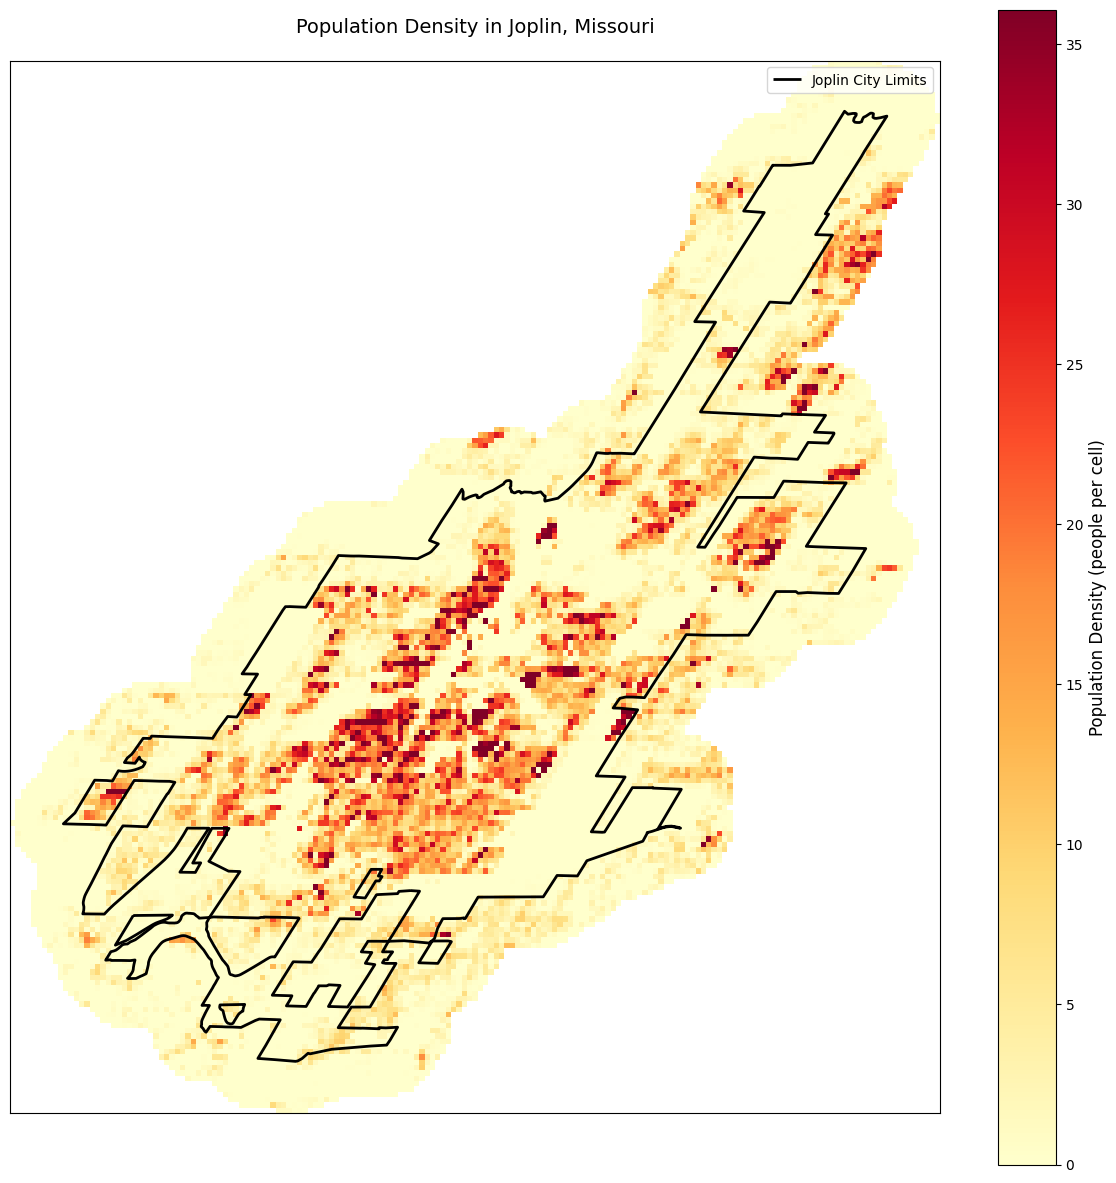

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))

# Plot population density with a better colormap
population = clipped_pop[0].values
im = ax.imshow(population,
              extent=[clipped_pop.x.min(), clipped_pop.x.max(),
                     clipped_pop.y.min(), clipped_pop.y.max()],
              cmap='YlOrRd',  # Yellow-Orange-Red colormap
              norm=plt.Normalize(vmin=0, vmax=np.percentile(population[population > 0], 98))  # Adjust color scaling
)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Population Density (people per cell)', fontsize=12)

# Plot Joplin boundary
joplin_boundary_moll.boundary.plot(ax=ax, color='black', linewidth=2, label='Joplin City Limits')

# Add title and legend
plt.title('Population Density in Joplin, Missouri', fontsize=14, pad=20)
plt.legend(fontsize=10)

# Remove axes coordinates
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [17]:
# Calculate statistics
total_pop = np.sum(population)
area_km2 = joplin_boundary_moll.area.iloc[0] / 1_000_000  # Convert m² to km²
density = total_pop / area_km2

print(f"Total Population: {total_pop:,.0f}")
print(f"Area: {area_km2:.2f} km²")
print(f"Average Population Density: {density:.1f} people per km²")

Total Population: nan
Area: 81.61 km²
Average Population Density: nan people per km²


In [18]:
population = clipped_pop[0].values
valid_pop = population[~np.isnan(population)]  # Remove NaN values
total_pop = np.sum(valid_pop)
area_km2 = joplin_boundary_moll.area.iloc[0] / 1_000_000  # Convert m² to km²
density = total_pop / area_km2

print(f"Total Population: {total_pop:,.0f}")
print(f"Area: {area_km2:.2f} km²")
print(f"Average Population Density: {density:.1f} people per km²")

# Also print some additional information for debugging
print("\nDebug information:")
print(f"Number of valid cells: {len(valid_pop)}")
print(f"Number of NaN cells: {np.sum(np.isnan(population))}")
print(f"Min population in a cell: {np.min(valid_pop):.2f}")
print(f"Max population in a cell: {np.max(valid_pop):.2f}")

Total Population: 71,377
Area: 81.61 km²
Average Population Density: 874.6 people per km²

Debug information:
Number of valid cells: 15834
Number of NaN cells: 18816
Min population in a cell: 0.00
Max population in a cell: 155.99


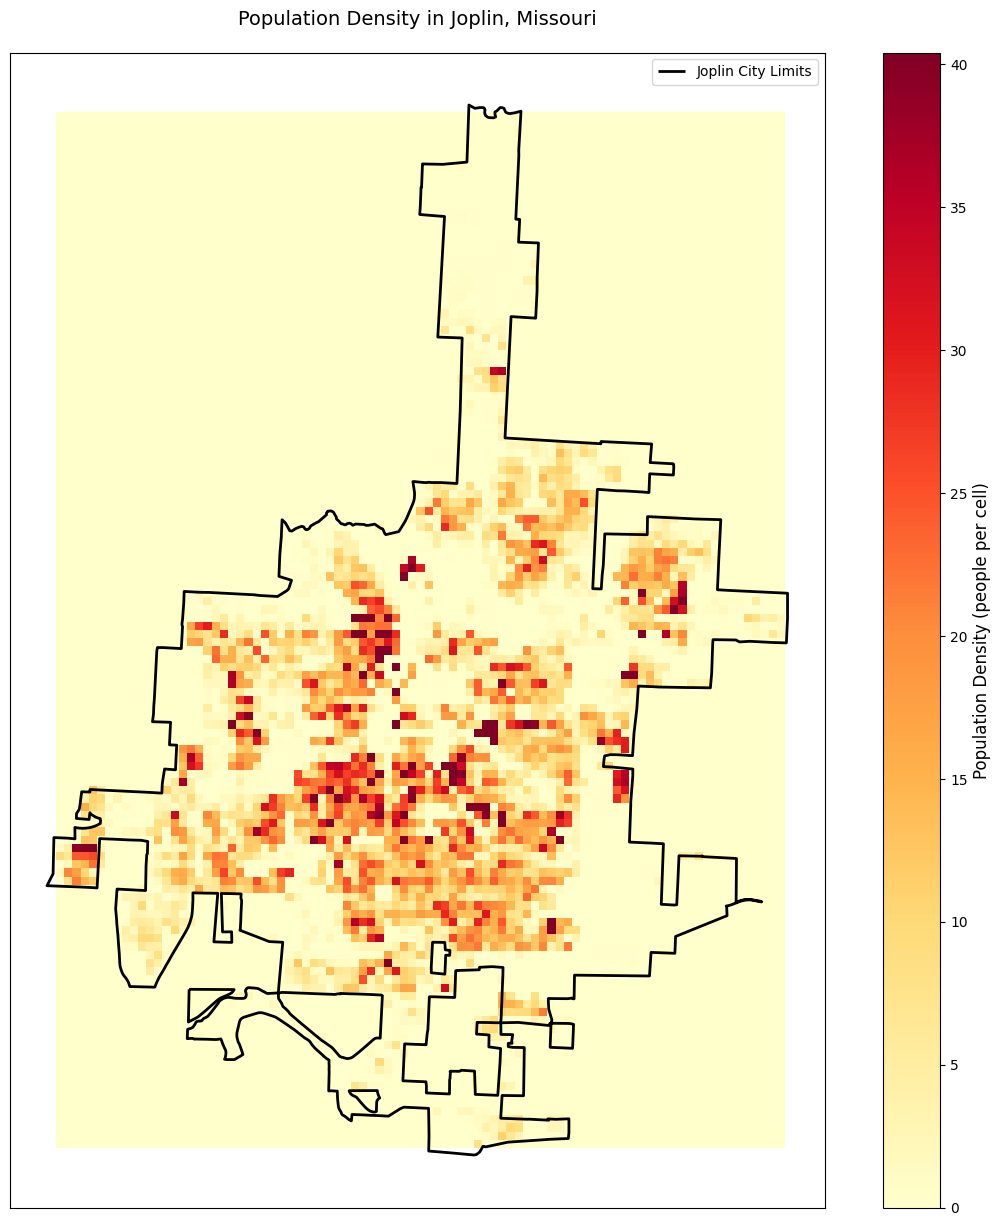

In [23]:
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
population_data = rioxarray.open_rasterio(
    r"C:\Users\yanit\OneDrive\Bureau\Data Insights And Visualization\GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R5_C10.tif",
    masked=False
)

# Load Joplin boundary and reproject to UTM Zone 15N (which covers Joplin)
joplin_boundary = gpd.read_file("joplin.geojson")
joplin_boundary_utm = joplin_boundary.to_crs('EPSG:32615')  # UTM Zone 15N

# Reproject population data to UTM
population_data_utm = population_data.rio.reproject('EPSG:32615')

# Clip the population data
clipped_pop = population_data_utm.rio.clip(joplin_boundary_utm.geometry)

# Create visualization
fig, ax = plt.subplots(figsize=(15, 15))

# Plot population density
population = clipped_pop[0].values
im = ax.imshow(population,
              extent=[clipped_pop.x.min(), clipped_pop.x.max(),
                     clipped_pop.y.min(), clipped_pop.y.max()],
              cmap='YlOrRd',
              norm=plt.Normalize(vmin=0, vmax=np.percentile(population[population > 0], 98))
)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Population Density (people per cell)', fontsize=12)

# Plot Joplin boundary
joplin_boundary_utm.boundary.plot(ax=ax, color='black', linewidth=2, label='Joplin City Limits')

# Add title and legend
plt.title('Population Density in Joplin, Missouri', fontsize=14, pad=20)
plt.legend(fontsize=10)

# Remove axes coordinates
ax.set_xticks([])
ax.set_yticks([])

plt.show()


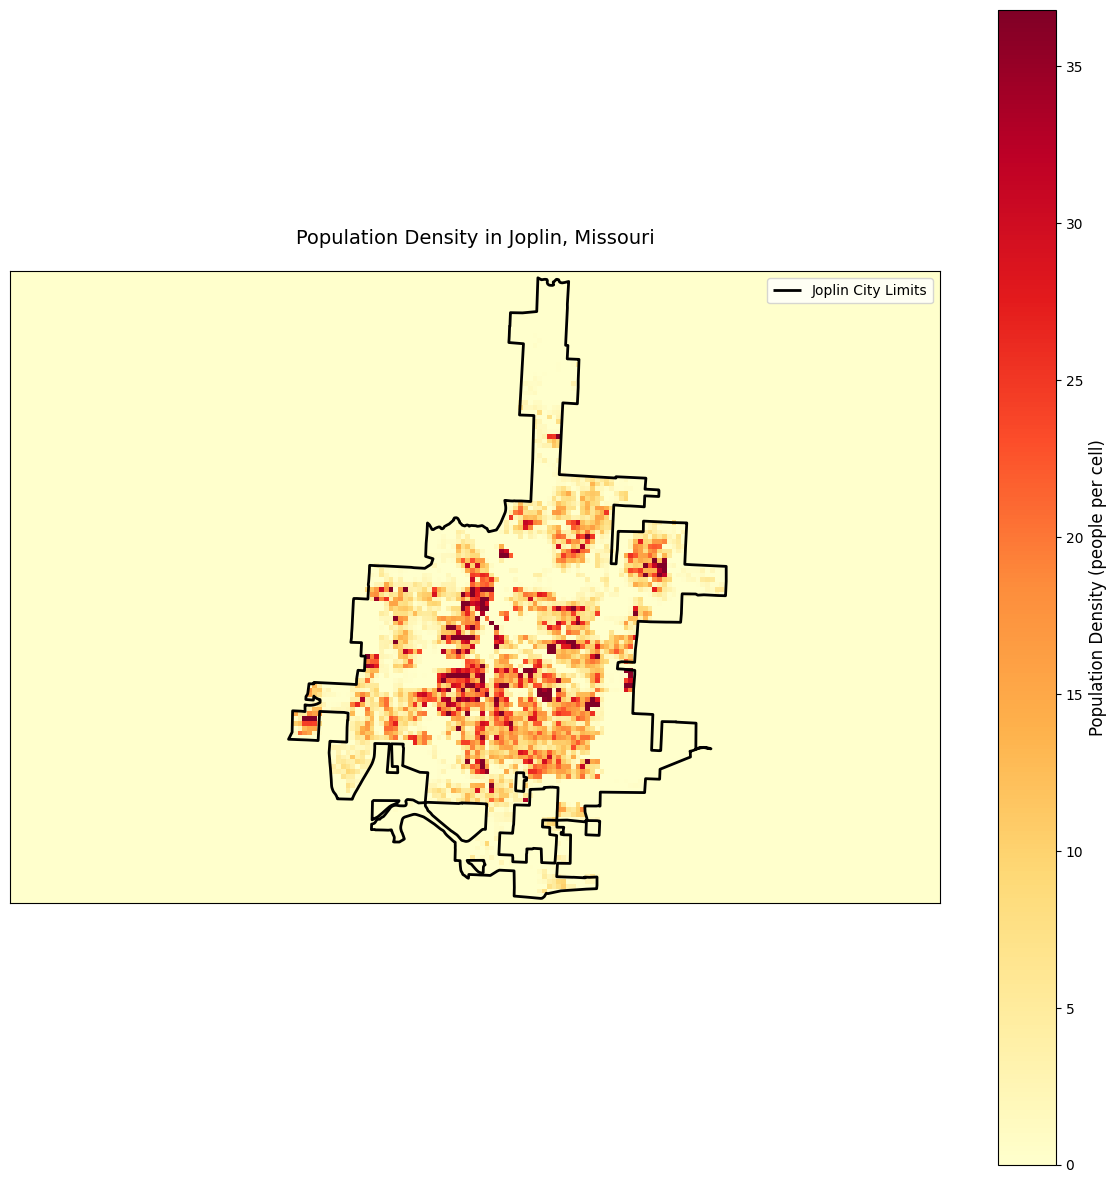

In [24]:
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
population_data = rioxarray.open_rasterio(
    r"C:\Users\yanit\OneDrive\Bureau\Data Insights And Visualization\GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R5_C10.tif",
    masked=False
)

# Load Joplin boundary
joplin_boundary = gpd.read_file("joplin.geojson")

# First clip in original projection
joplin_boundary_moll = joplin_boundary.to_crs('ESRI:54009')
clipped_pop_moll = population_data.rio.clip(joplin_boundary_moll.geometry)

# Then reproject to UTM
clipped_pop_utm = clipped_pop_moll.rio.reproject('EPSG:32615')
joplin_boundary_utm = joplin_boundary.to_crs('EPSG:32615')

# Create visualization
fig, ax = plt.subplots(figsize=(15, 15))

# Plot population density
population = clipped_pop_utm[0].values
valid_pop = population[~np.isnan(population)]  # Remove NaN values
valid_pop = valid_pop[valid_pop >= 0]  # Remove any negative values that might have been introduced

im = ax.imshow(population,
              extent=[clipped_pop_utm.x.min(), clipped_pop_utm.x.max(),
                     clipped_pop_utm.y.min(), clipped_pop_utm.y.max()],
              cmap='YlOrRd',
              norm=plt.Normalize(vmin=0, vmax=np.percentile(valid_pop, 98))
)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Population Density (people per cell)', fontsize=12)

# Plot Joplin boundary
joplin_boundary_utm.boundary.plot(ax=ax, color='black', linewidth=2, label='Joplin City Limits')

# Add title and legend
plt.title('Population Density in Joplin, Missouri', fontsize=14, pad=20)
plt.legend(fontsize=10)

# Remove axes coordinates
ax.set_xticks([])
ax.set_yticks([])

plt.show()

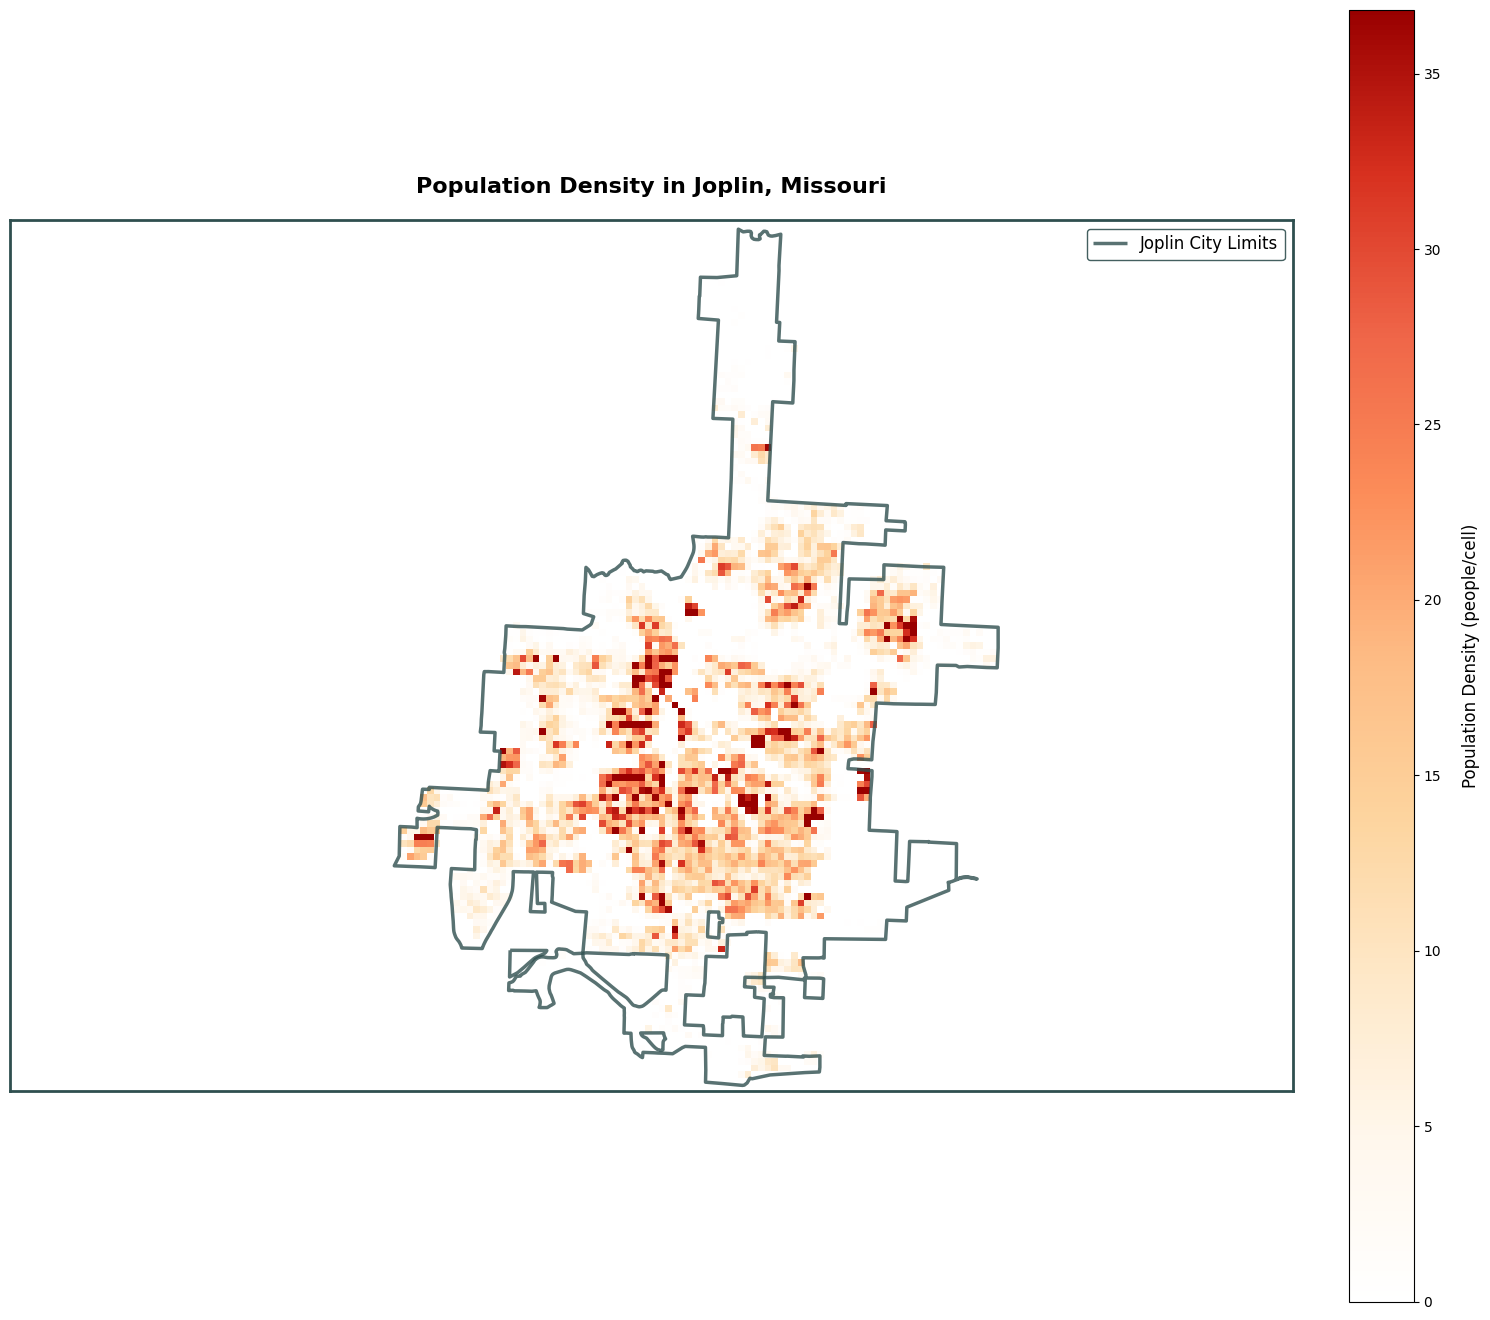

In [25]:
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Load the data
population_data = rioxarray.open_rasterio(
    r"C:\Users\yanit\OneDrive\Bureau\Data Insights And Visualization\GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R5_C10.tif",
    masked=False
)

# Load Joplin boundary
joplin_boundary = gpd.read_file("joplin.geojson")

# First clip in original projection
joplin_boundary_moll = joplin_boundary.to_crs('ESRI:54009')
clipped_pop_moll = population_data.rio.clip(joplin_boundary_moll.geometry)

# Then reproject to UTM
clipped_pop_utm = clipped_pop_moll.rio.reproject('EPSG:32615')
joplin_boundary_utm = joplin_boundary.to_crs('EPSG:32615')

# Create visualization with a white background
fig, ax = plt.subplots(figsize=(15, 15), facecolor='white')
ax.set_facecolor('white')

# Create custom colormap from white to dark red
colors = ['#ffffff', '#fff7ec', '#fee8c8', '#fdd49e', '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000']
n_bins = 256  # Number of color gradients
custom_cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)

# Plot population density
population = clipped_pop_utm[0].values
valid_pop = population[~np.isnan(population)]
valid_pop = valid_pop[valid_pop >= 0]

im = ax.imshow(population,
              extent=[clipped_pop_utm.x.min(), clipped_pop_utm.x.max(),
                     clipped_pop_utm.y.min(), clipped_pop_utm.y.max()],
              cmap=custom_cmap,
              norm=plt.Normalize(vmin=0, vmax=np.percentile(valid_pop, 98))
)

# Add smaller colorbar with formatted labels
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Make colorbar smaller
cbar.set_label('Population Density (people/cell)', fontsize=12, labelpad=15)
# Format colorbar labels to include comma separators
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Plot Joplin boundary with a more aesthetic style
joplin_boundary_utm.boundary.plot(
    ax=ax,
    color='#2F4F4F',  # Dark slate gray
    linewidth=2.5,
    linestyle='-',
    label='Joplin City Limits',
    alpha=0.8
)

# Add title and legend with improved styling
plt.title('Population Density in Joplin, Missouri', 
          fontsize=16, 
          pad=20, 
          fontweight='bold', 
          fontfamily='sans-serif')

# Improve legend appearance
leg = plt.legend(fontsize=12, 
                loc='upper right',
                frameon=True,
                facecolor='white',
                edgecolor='#2F4F4F',
                framealpha=0.9)

# Remove axes coordinates
ax.set_xticks([])
ax.set_yticks([])

# Add a subtle border around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('#2F4F4F')
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

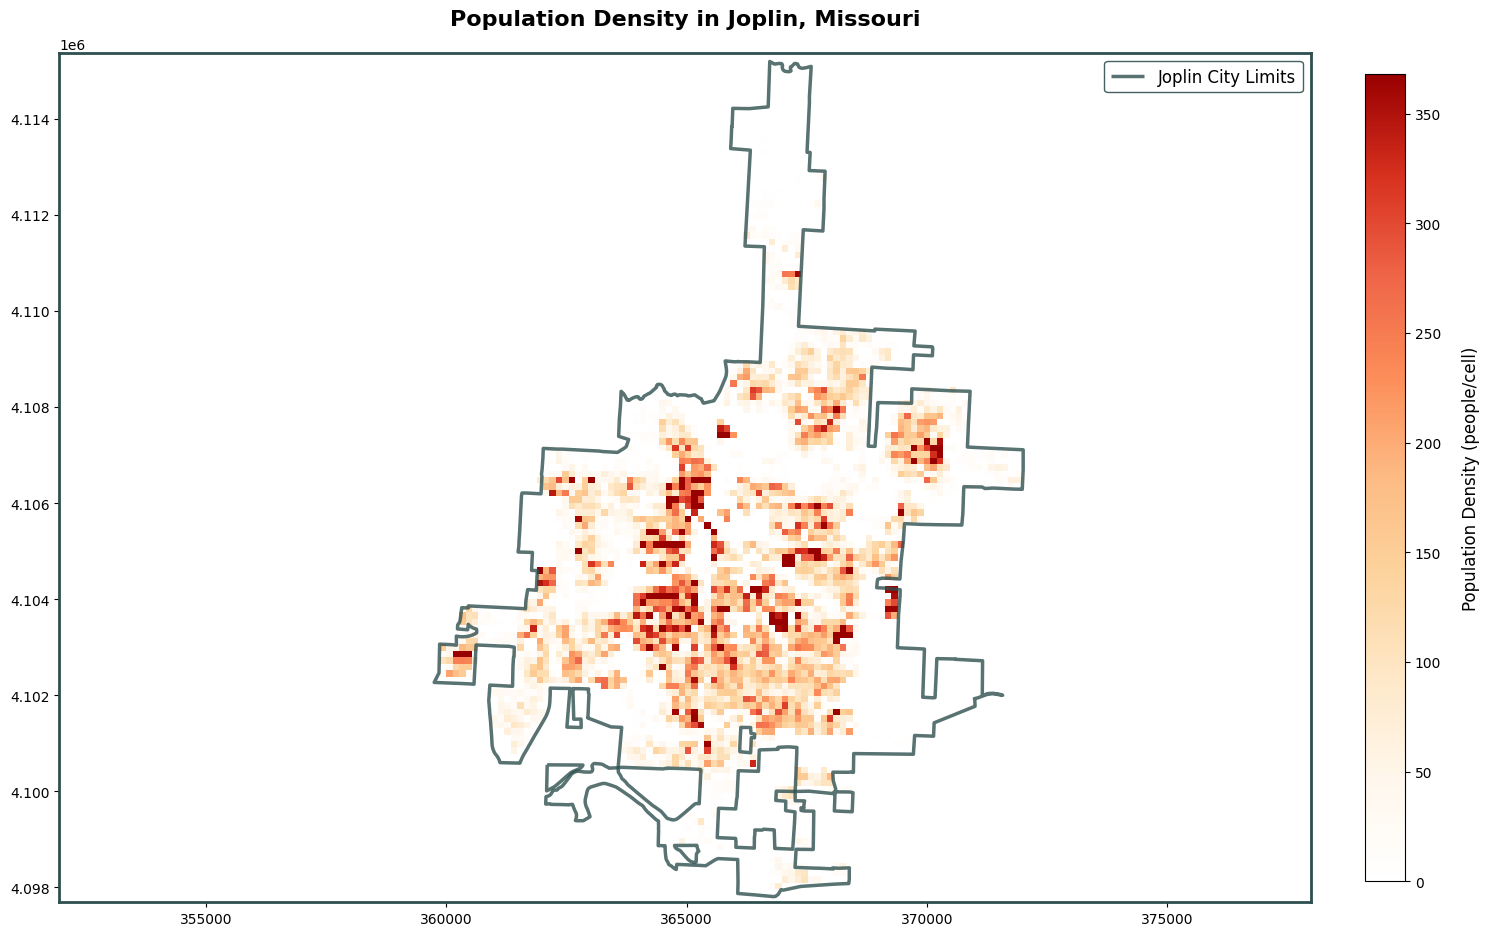

In [7]:
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Load the data
population_data = rioxarray.open_rasterio(
    r"C:\Users\yanit\OneDrive\Bureau\Data Insights And Visualization\GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R5_C10.tif",
    masked=False
)

# Load Joplin boundary
joplin_boundary = gpd.read_file(r"C:\Users\yanit\OneDrive\Bureau\Data Insights And Visualization\elevation\joplin.geojson")

# First clip in original projection
joplin_boundary_moll = joplin_boundary.to_crs('ESRI:54009')
clipped_pop_moll = population_data.rio.clip(joplin_boundary_moll.geometry)

# Then reproject to UTM
clipped_pop_utm = clipped_pop_moll.rio.reproject('EPSG:32615')
joplin_boundary_utm = joplin_boundary.to_crs('EPSG:32615')

# Create visualization with a white background
fig, ax = plt.subplots(figsize=(15, 15), facecolor='white')
ax.set_facecolor('white')

# Create custom colormap from white to dark red
colors = ['#ffffff', '#fff7ec', '#fee8c8', '#fdd49e', '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000']
n_bins = 256  # Number of color gradients
custom_cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)

# Plot population density
population = clipped_pop_utm[0].values * 10  # Multiply by 10 to scale up the values
valid_pop = population[~np.isnan(population)]
valid_pop = valid_pop[valid_pop >= 0]

im = ax.imshow(population,
              extent=[clipped_pop_utm.x.min(), clipped_pop_utm.x.max(),
                     clipped_pop_utm.y.min(), clipped_pop_utm.y.max()],
              cmap=custom_cmap,
              norm=plt.Normalize(vmin=0, vmax=np.percentile(valid_pop, 98))
)

# Add even smaller colorbar with formatted labels
cbar = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.04)  # Reduced fraction for smaller colorbar
cbar.set_label('Population Density (people/cell)', fontsize=12, labelpad=15)
# Format colorbar labels to include comma separators
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Plot Joplin boundary with a more aesthetic style
joplin_boundary_utm.boundary.plot(
    ax=ax,
    color='#2F4F4F',  # Dark slate gray
    linewidth=2.5,
    linestyle='-',
    label='Joplin City Limits',
    alpha=0.8
)

# Add title and legend with improved styling
plt.title('Population Density in Joplin, Missouri', 
          fontsize=16, 
          pad=20, 
          fontweight='bold', 
          fontfamily='sans-serif')

# Improve legend appearance
leg = plt.legend(fontsize=12, 
                loc='upper right',
                frameon=True,
                facecolor='white',
                edgecolor='#2F4F4F',
                framealpha=0.9)

# Remove axes coordinates

# Add a subtle border around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('#2F4F4F')
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()



In [ ]:
# Try clipping without masking
population_data = rioxarray.open_rasterio(
    r"C:\Users\yanit\OneDrive\Bureau\Data Insights And Visualization\GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R5_C10.tif",
    masked=False  # Change this to False
)

# Then clip and calculate statistics
joplin_boundary_moll = joplin_boundary.to_crs('ESRI:54009')
clipped_pop = population_data.rio.clip(joplin_boundary_moll.geometry)

In [11]:
import pandas as pd
import plotly.express as px

# Read the data
df = pd.read_csv(r'C:\Users\yanit\OneDrive\Bureau\Data Insights And Visualization\poi_sunda.csv')


# Calculate total counts for each damage type and round to integers
damage_counts = {
    'Destroyed': round(df['destroyed'].sum()),
    'Major Damage': round(df['major-damage'].sum()),
    'Unclassified': round(df['un-classified'].sum()),
    'No Damage': round(df['no-damage'].sum())
}

# Convert to DataFrame for plotting
damage_df = pd.DataFrame({
    'Damage Type': list(damage_counts.keys()),
    'Count': list(damage_counts.values())
})

# Create interactive bar plot with a new color scheme
fig = px.bar(
    damage_df,
    x='Damage Type',
    y='Count',
    title='Total Count per Damage Type - Suna',
    color='Damage Type',
    color_discrete_sequence=['#E74C3C', '#28B463', '#F39C12', '#A3A8AE', '#2E86C1'],  # Professional color palette
    text='Count',
    height=600
)

# Customize the layout
fig.update_layout(
    title_font_size=24,
    title_x=0.5,
    xaxis_title='Damage Type',
    yaxis_title='Total Count',
    showlegend=False,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(
        tickangle=45,
        tickfont=dict(size=14)
    ),
    yaxis=dict(
        tickfont=dict(size=14)
    )
)

# Add hover template
fig.update_traces(
    hovertemplate='<b>%{x}</b><br>Count: %{y}<extra></extra>',
    textposition='outside'
)

fig.write_html("damage_type_barplot_suna.html")

In [9]:
import pandas as pd

# Read the data
df = pd.read_csv(r'C:\Users\yanit\OneDrive\Bureau\Data Insights And Visualization\poi_sunda.csv')

# Print the column names to see what we're working with
print("Column names in the file:")
print(df.columns.tolist())

Column names in the file:
['sensor', 'provider_asset_type', 'gsd', 'capture_date', 'off_nadir_angle', 'pan_resolution', 'sun_azimuth', 'sun_elevation', 'target_azimuth', 'disaster', 'disaster_type', 'catalog_id', 'original_width', 'original_height', 'width', 'height', 'id', 'img_name', 'centroid_x', 'centroid_y', 'path', 'no-damage', 'un-classified', 'destroyed', 'major-damage']
